### Group Members:  Jo Ann Elias  &  Marcia Cosgrove

# UCD Bootcamp ETL Project 

For our project, we created a SQL Alchemy database connecting three different data sources regarding influenza and Covid-19 cases. Each source is at a different level of aggregation, which we address in the transformation section of this project. This primary subject of the database is the state of California.

•	<b>California Historical Influenza Surveillance Data</b><br>
Data Source: CA Dept of Health & Human Services - Influenza Surveillance<br>
https://data.chhs.ca.gov/dataset/influenza-surveillance<br>
<br>
•	<b>United States Covid-19 Hospital Needs & Death Projections</b><br>
Data Source: Institute for Health Metrics and Evaluation (IHME), data codebook included with download<br>
http://www.healthdata.org/covid<br>
<br>
•	<b>Global Covid-19 Cases & Deaths</b><br>
Data Source: Data World contributor Mark Di Marco compiles daily stats from European Centre for Disease Prevention and Control<br>
https://data.world/markmarkoh/coronavirus-data<br>
<br>
<b>Our database can answer questions like:</b><br> 
•	Compared to CA’s historical influenza infection rates, which regions are likely to be in greatest demand for Covid-19 flu related health services?<br>
•	How does CA’s hospital capacity and Covid-19 projections compare to the rest of the US?<br>
•	How does CA’s Covid-19 projections compare to the infection rates globally?<br>
<br>
<b>* Background Note:</b> SARS-CoV-2 is the name of the 2019 novel coronavirus, Covid-19 is the name of the respiratory disease it causes.

#  (E) - Data Extraction

* Import Needed Libraries
* Load CSV Files
* Read CSV Files & Store in Dataframes
* ERD of Data Sources

In [15]:
#####  *** Set Up ***  #####

### Import Dependencies
import pandas as pd
import numpy as np
import datetime as dt

### Python SQL Toolkit & Object Relational Mapper (ORM)
import psycopg2
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

### Files to Load 
CA_Hist_Flu_data = "Resources/CA_Historical_Influenza.csv"
US_Hosp_Capacity_data = "Resources/US_Hsp_Capacity_Projections.csv"
Global_Covid19_data = "Resources/Global_Covid19.csv"

### Read CSV Files & Store in Pandas Dataframes
CA_Hist_Flu = pd.read_csv(CA_Hist_Flu_data, encoding='unicode_escape')
US_Hosp_Capacity = pd.read_csv(US_Hosp_Capacity_data, encoding='unicode_escape')
Global_Covid19 = pd.read_csv(Global_Covid19_data, encoding='unicode_escape')

### Quick DBD Diagram of Data Sources & Transformations Needed (indicated by "Add_")


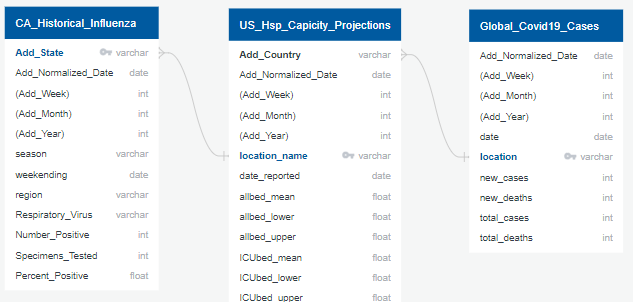

In [16]:
#### Set Dataframes to Show All Columns in Output Window
pd.set_option("display.max_columns", None)

#### Check Dataframe Datatypes
# CA_Hist_Flu.dtypes
# US_Hosp_Capacity.dtypes
# Global_Covid19.dtypes

#### Display Dataframes
# CA_Hist_Flu.head()
# US_Hosp_Capacity.head()
Global_Covid19.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0


# (T) - Data Transformation

* Drop Columns that are Not Needed
* Create Columns that are Needed
* Rename Columns for Consistency Across Dataframes
* Reorder Columns for Consistency Across Dataframes


In [17]:
##### *** DROP COLUMNS from Dataframes that Aren't Needed *** ###############################


################ CA_Hist_Flu - Drop Columns #################################################

## Drop "date_code" - Seems to be an internal dept code
CA_Hist_Flu=CA_Hist_Flu.drop(columns=["date_code"], axis=1)

################ Global_Covid19 Dataframe - Drop Columns #####################################

## Drop the one observation for 2019 (12/31/19), keep only 2020 observations
Global_Covid19 = Global_Covid19.drop([0,0]) 


### ** Display Dataframes ** ####################
# CA_Hist_Flu.head()
# US_Hosp_Capacity.head()
# Global_Covid19.head()

In [18]:
##### ***  CREATE NEW COLUMNS & Needed Primary Keys *** ########################################


################ CA_Hist_Flu - Create New Columns ##############################################

## Add Foreign Keys (for joining to US_Hosp_Capacity & Global_Covid19 tables)
CA_Hist_Flu['State'] = 'California'
CA_Hist_Flu['Country'] = 'United States'
CA_Hist_Flu['index_Region'] = CA_Hist_Flu['region']

## Standardized Date Columns
CA_Hist_Flu['Date'] = pd.to_datetime(CA_Hist_Flu['weekending'])
CA_Hist_Flu['Week_Day'] = CA_Hist_Flu['Date'].dt.weekday_name
CA_Hist_Flu['Week_Number'] = CA_Hist_Flu['Date'].dt.week
CA_Hist_Flu['Month'] = CA_Hist_Flu['Date'].dt.month
CA_Hist_Flu['Year'] = CA_Hist_Flu['Date'].dt.year


################ US_Hosp_Capacity - Create New Columns ########################################

## Add Foreign Key (for joining to Global_Covid19 table)
US_Hosp_Capacity['Country'] = 'United States'
US_Hosp_Capacity['index_State'] = US_Hosp_Capacity['location_name']

## Standardized Date Columns
US_Hosp_Capacity['Date'] = pd.to_datetime(US_Hosp_Capacity['date_reported'])
US_Hosp_Capacity['Week_Day'] = US_Hosp_Capacity['Date'].dt.weekday_name
US_Hosp_Capacity['Week_Number'] = US_Hosp_Capacity['Date'].dt.week
US_Hosp_Capacity['Month'] = US_Hosp_Capacity['Date'].dt.month
US_Hosp_Capacity['Year'] = US_Hosp_Capacity['Date'].dt.year


################ Global_Covid19 - Create New Columns ############################################

## Add an Index Column to Set as Primary Key for PostregSQL
Global_Covid19['index_Country'] = Global_Covid19['location']

## Standardized Date Columns
Global_Covid19['Date'] = pd.to_datetime(Global_Covid19['date'])
Global_Covid19['Week_Day'] = Global_Covid19['Date'].dt.weekday_name
Global_Covid19['Week_Number'] = Global_Covid19['Date'].dt.week
Global_Covid19['Month'] = Global_Covid19['Date'].dt.month
Global_Covid19['Year'] = Global_Covid19['Date'].dt.year


### ** Display Dataframes ** ####################
CA_Hist_Flu.head()
# US_Hosp_Capacity.head()
# Global_Covid19.head()

,season,weekending,region,Respiratory_Virus,Number_Positive,Specimens_Tested,Percent_Positive,State,Country,index_Region,Date,Week_Day,Week_Number,Month,Year
0,2009-2010,10/10/09,Bay Area,Influenza_A,36,220,16.36,California,United States,Bay Area,2009-10-10,Saturday,41,10,2009
1,2009-2010,10/10/09,Bay Area,Influenza_B,0,220,0.00,California,United States,Bay Area,2009-10-10,Saturday,41,10,2009
2,2009-2010,10/10/09,Bay Area,Total_Influenza,36,220,16.36,California,United States,Bay Area,2009-10-10,Saturday,41,10,2009
3,2009-2010,10/10/09,Bay Area,RSV,0,190,0.00,California,United States,Bay Area,2009-10-10,Saturday,41,10,2009
4,2009-2010,10/10/09,California,Influenza_A,1077,3324,32.40,California,United States,California,2009-10-10,Saturday,41,10,2009


In [19]:
##### *** Standardize Existing Columns - RENAMING FOR CONSISTENCY *** #######################


################ CA_Hist_Flu Dataframe #####################################################

CA_Hist_Flu = CA_Hist_Flu.rename(columns={"season": "Flu_Season", 
                                          "weekending": "Week_Ending", 
                                          "region":"Region"})

################ US_Hosp_Capacity Dataframe #################################################

US_Hosp_Capacity = US_Hosp_Capacity.rename(columns={"location_name": "State"})

################ Global_Covid19 Dataframe ###################################################

Global_Covid19 = Global_Covid19.rename(columns={"location": "Country",
                                                "new_cases":"New_Cases", 
                                                "new_deaths":"New_Deaths", 
                                                "total_cases": "Total_Cases", 
                                                "total_deaths":"Total_Deaths"})


### ** Display Dataframes ** ####################
# CA_Hist_Flu.head()
# US_Hosp_Capacity.head()
# Global_Covid19.head()

In [20]:
##### ***  Set Dataframe Indices to for Primary Keys in PostgreSQL *** ########################################

CA_Hist_Flu.set_index('index_Region', inplace=True)
US_Hosp_Capacity.set_index('index_State', inplace=True)
Global_Covid19.set_index('index_Country', inplace=True)


In [21]:
##### *** Standardize Existing Columns - REORDERING FOR CONSISTENCY *** ############################


################ CA_Hist_Flu Dataframe #####################################################

CA_Hist_Flu = CA_Hist_Flu[['Country', 'State', 'Region',
                           'Flu_Season','Week_Ending', 'Date',
                           'Week_Day', 'Week_Number', 'Month', 'Year',
                           'Respiratory_Virus','Number_Positive',
                           'Specimens_Tested','Percent_Positive']]




################ US_Hsp_Capacity Dataframe #################################################

US_Hosp_Capacity = US_Hosp_Capacity[['Country', 'State','Date','Week_Day', 
                                    'Week_Number', 'Month', 'Year','allbed_mean',
                                    'allbed_lower','allbed_upper','ICUbed_mean',
                                    'ICUbed_lower','ICUbed_upper','InvVen_mean',
                                    'InvVen_lower','InvVen_upper','deaths_mean',
                                    'deaths_lower', 'deaths_upper','admis_mean',
                                    'admis_lower','admis_upper','newICU_mean',
                                    'newICU_lower','newICU_upper','totdea_mean',
                                    'totdea_lower','totdea_upper','bedover_mean',
                                    'bedover_lower','bedover_upper','icuover_mean',
                                    'icuover_lower','icuover_upper']]

################ Global_Covid19 Dataframe  #################################################

Global_Covid19 = Global_Covid19[['Country','Date', 'Week_Day', 'Week_Number', 'Month', 
                                 'Year','New_Cases', 'New_Deaths','Total_Cases', 'Total_Deaths']]


### ** Display Dataframes ** ####################
# CA_Hist_Flu.head()
# US_Hosp_Capacity.head()
# Global_Covid19.head()

# (L) - Data Load

* Create Engine
* Create Connection Layer to the Database
* Use Pandas to Load CSV Converted Dataframes to PostreSQL
* Create a Session from Python to PostreSQL
* Create Our Session (link) from Python to the DB

In [22]:
##### ***  Create Engine & Connection Layer *** #################################

connection_string = "postgres:postgres@localhost:5432/covid19_db"
engine = create_engine(f'postgresql://{connection_string}')
connection = engine.connect()


In [23]:
### Use Pandas to Load CSV Converted Dataframe into Database

CA_Hist_Flu.to_sql(name='ca_hist_flu', con=engine, if_exists='append', index=False)
US_Hosp_Capacity.to_sql(name='us_hosp_capacity', con=engine, if_exists='append', index=False)
Global_Covid19.to_sql(name='global_covid19', con=engine, if_exists='append', index=False)


In [24]:
# Check Tables in Postgres (pgAdmin4):
engine.table_names()

['ca_hist_flu', 'us_hosp_capacity', 'global_covid19']

In [25]:
## Create Our Session (link) from Python to the DB
session = Session(engine)

#  You Are Now Able to Query the Database!!

In [26]:
### Confirm data has been added by querying the database
pd.read_sql_query('select * from CA_Hist_Flu', con=engine).head()

,Country,State,Region,Flu_Season,Week_Ending,Date,Week_Day,Week_Number,Month,Year,Respiratory_Virus,Number_Positive,Specimens_Tested,Percent_Positive
0,United States,California,Bay Area,2009-2010,10/10/09,2009-10-10,Saturday,41,10,2009,Influenza_A,36,220,16.36
1,United States,California,Bay Area,2009-2010,10/10/09,2009-10-10,Saturday,41,10,2009,Influenza_B,0,220,0.00
2,United States,California,Bay Area,2009-2010,10/10/09,2009-10-10,Saturday,41,10,2009,Total_Influenza,36,220,16.36
3,United States,California,Bay Area,2009-2010,10/10/09,2009-10-10,Saturday,41,10,2009,RSV,0,190,0.00
4,United States,California,California,2009-2010,10/10/09,2009-10-10,Saturday,41,10,2009,Influenza_A,1077,3324,32.40


In [27]:
### Confirm data has been added by querying the database
pd.read_sql_query('select * from global_covid19', con=engine).head()

,Country,Date,Week_Day,Week_Number,Month,Year,New_Cases,New_Deaths,Total_Cases,Total_Deaths
0,Afghanistan,2020-01-01,Wednesday,1,1,2020,0,0,0,0
1,Afghanistan,2020-01-02,Thursday,1,1,2020,0,0,0,0
2,Afghanistan,2020-01-03,Friday,1,1,2020,0,0,0,0
3,Afghanistan,2020-01-04,Saturday,1,1,2020,0,0,0,0
4,Afghanistan,2020-01-05,Sunday,1,1,2020,0,0,0,0


In [28]:
### Confirm data has been added by querying the database
pd.read_sql_query('select * from us_hosp_capacity', con=engine).head()

,Country,State,Date,Week_Day,Week_Number,Month,Year,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,InvVen_upper,deaths_mean,deaths_lower,deaths_upper,admis_mean,admis_lower,admis_upper,newICU_mean,newICU_lower,newICU_upper,totdea_mean,totdea_lower,totdea_upper,bedover_mean,bedover_lower,bedover_upper,icuover_mean,icuover_lower,icuover_upper
0,United States,Alabama,2020-02-06,Thursday,6,2,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,United States,Alabama,2020-02-07,Friday,6,2,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,United States,Alabama,2020-02-08,Saturday,6,2,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,United States,Alabama,2020-02-09,Sunday,6,2,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,United States,Alabama,2020-02-10,Monday,7,2,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
